In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from ast import literal_eval
import matplotlib.pyplot as plt

# Functions for Pipeline

In [87]:
def drop_categories(df):
    # this function drops all categories of API output which are irrelevant for prediction
    
    # keep only important columns
    df.drop(["dlc", "review_score_desc", "legal_notice", "recommendations", "ext_user_account_notice", "reviews", "metacritic", "demos", 
            "drm_notice", "alternate_appid", "screenshots", "movies", "support_info", "background", "background_raw", 
            "content_descriptors", "packages", "package_groups", "num_reviews", "developers", "achievements", 
            "detailed_description", "about_the_game", "supported_languages", "header_image", "website", "categories_clean", "genres_clean", 
            "platforms_clean"
            ], axis = 1, inplace=True)

    # keep only important categories
    df.drop(['Partial Controller Support', 'Captions available', 'Remote Play on Phone',  'Steam Turn Notifications', 'Steam Trading Cards',
            'Remote Play on TV', 'Includes Source SDK', 'SteamVR Collectibles', 'Commentary available', 'Includes level editor', 
            'Tracked Controller Support',  'Steam Workshop', 'Additional High-Quality Audio', 'Steam Cloud', 'Remote Play on Tablet'
            ], axis = 1, inplace=True)

    # keep only important genres
    df.drop(['Design & Illustration', 'Audio Production', 'Photo Editing', 'Video Production', 'Game Development', 'Software Training',
                'Web Publishing', 'Animation & Modeling', 'Utilities'
                ], axis = 1, inplace=True)

    # remove russian genres 
    df.drop(['Экшены','Бесплатно', 'Дизайн и иллюстрация', 'Создание видео', 'Анимация и моделирование', 'Многопользовательские игры', 
              'Приключенческие игры'
             ], axis = 1, inplace=True)
    
        # remove russian categories 
    df.drop(['Контроллер (полностью)',  'Remote Play на телевизоре', 'Достижения Steam',  'Для нескольких игроков', 'Статистика', 'Коллекционные карточки', 
            'Покупки внутри приложения','Remote Play на телефоне', 'Мастерская Steam', 'Имеется античит Valve', 'Remote Play на планшете', 'Против игроков (по сети)',
            'Против игроков'
            
            ], axis = 1, inplace=True) 

In [88]:
def drop_few_review_games(df, num_reviews=50):
    # drop games with less than num_reviews reviews. also reset the index after dropping rows
    df =  df.loc[lambda df: df['total_reviews'] >= num_reviews, :].reset_index(drop=True)
    return df

In [89]:
def drop_high_price_games(df, max_price=200):
    # drops few outlier games which have unreasonably high prices. max price is price in euros (price/100)
    df=  df.loc[lambda df: df.price_overview_clean/100 <= max_price, :].reset_index(drop=True)
    return df

In [90]:
def clean_col(df, col):
    # this function takes the API output of the column col categories and cleans it up
    # categories are shown in a list in new column "col_clean" in output dataframe
    
    new_col = col + "_clean"
    
    df[new_col] =  0 if col == "price_overview" else ""
    
    # iterate through rows
    for index, row in df.iterrows():
        
        # prefilter games without price dict
        if col == "price_overview" and row.is_free:
            continue
        
        # try to read the entry as a dictionary
        try:
            dict = literal_eval(str(row[col]).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
        
        # if possible
        else:
            
            # get price
            if col == "price_overview":
                
                # if currency is not EUR
                if dict["currency"] != "EUR":
                    
                    # delete row
                    df.drop(index, inplace=True)
            
                # get price
                else:
                    df[new_col].loc[index] = dict["initial"]
            
            else:
                categories = []
                
                # get platforms
                if col == "platforms":
                    categories = list({k: v for k, v in dict.items() if v}.keys())
                
                # or get categories/genres 
                else:
                    for j in range(len(dict)):
                        categories.append(dict[j]["description"])
                
                df[new_col].loc[index] = np.array(categories)
                    
    df = df.drop(col, axis=1).reset_index(drop=True)

    return df

In [91]:
def get_set(df, col):
    # this function iterates through the new column "genres_clean" and return the set of unique genres contained in the dataframe
    G = []
    
    for idx,row in df.iterrows():
        
        for j in range(len(row[col])):
            G.append(row[col][j])
    
    return list(set(G))
        

In [92]:
def one_hot_encode(df, G, col):
    # this function creates a new column for each unique genre in the dataframe to one-hot-encode it.
    for j in G:
        df[j] = 0
    
    for idx,row in df.iterrows():
       for category in row[col]:
           df[category].loc[idx] = 1

    return df

# Pipeline

In [93]:
df = pd.read_csv("raw_data.csv", index_col=0, low_memory=False)

In [94]:
# clean and pre-process data

df = drop_few_review_games(df, num_reviews=50)

df = clean_col(df, "price_overview")
df = drop_high_price_games(df, max_price=200)

df = clean_col(df, "genres")
genre_set = get_set(df, "genres_clean")
df = one_hot_encode(df, genre_set, "genres_clean")

df = clean_col(df, "categories")
category_set = get_set(df, "categories_clean")
df = one_hot_encode(df, category_set, "categories_clean")

df = clean_col(df, "platforms")
platform_set = get_set(df, "platforms_clean")
df = one_hot_encode(df, platform_set, "platforms_clean")

drop_categories(df)

/Users/emilbreustedt/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/emilbreustedt/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [95]:
df

,appid,name,review_score,total_positive,total_negative,total_reviews,type,required_age,is_free,short_description,...,Steam-Errungenschaften,LAN PvP,In-App Purchases,Remote Play auf Tablets,Online PvP,VR Supported,LAN Co-op,mac,windows,linux
0,1648390,ScooterFlow,8,446,21,467,game,0,False,The world’s most realistic freestyle scooter g...,...,0,0,0,0,0,0,0,0,1,0
1,1648610,Malum,6,146,53,199,game,0,False,Malum is the premier C-list horror game. Run f...,...,0,0,0,0,0,0,0,0,1,0
2,1647962,Hell Let Loose – Lethal Tide,8,70,6,76,dlc,0,False,Unlock access to the Lethal Tide DLC.,...,0,0,0,0,1,0,0,0,1,0
3,1647550,NEO: The World Ends with You,8,224,11,235,game,0,False,&quot;Only the possibility of you can change o...,...,0,0,0,0,0,0,0,0,1,0
4,1647730,Zool Redimensioned,8,68,2,70,game,0,False,The Ninja of the Nth Dimension is back! Explor...,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,523770,Of Bird And Cage,8,79,17,96,game,0,False,Of Bird and Cage is a unique metal album prese...,...,0,0,0,0,0,0,0,0,1,0
5640,230410,Warframe,8,991,137,1128,game,16,True,Awaken as an unstoppable warrior and battle al...,...,0,0,1,0,0,0,0,0,1,0
5641,1878070,Roma Invicta,8,73,11,84,game,0,False,Roma Invicta combines action packed real-time ...,...,0,0,0,0,0,0,0,1,1,1
5642,288370,Strike Suit Zero: Director's Cut,8,194,45,239,game,0,False,"In the year 2299, an interstellar war rages on...",...,0,0,0,0,0,0,0,0,1,0


In [96]:
df.to_csv('clean_data.csv')
df.head(100).to_csv('clean_data_small.csv')
df.columns

Index(['appid', 'name', 'review_score', 'total_positive', 'total_negative',
       'total_reviews', 'type', 'required_age', 'is_free', 'short_description',
       'pc_requirements', 'mac_requirements', 'linux_requirements',
       'publishers', 'release_date', 'controller_support', 'fullgame',
       'price_overview_clean', 'Adventure', 'Massively Multiplayer',
       'Sexual Content', 'Nudity', 'Racing', 'Indie', 'Violent', 'Стратегии',
       'Aktion', 'Free to Play', 'RPG', 'Abenteuer', 'Early Access',
       'Education', 'Action', 'Simulation', 'Strategy', 'Casual', 'Sports',
       'Gore', 'Full controller support', 'Steam Achievements',
       'Downloadable Content', 'Steam Leaderboards', 'Multi-player', 'PvP',
       'Co-op', 'VR Only', 'MMO', 'Valve Anti-Cheat enabled',
       'Shared/Split Screen', 'Remote Play Together', 'VR Support',
       'Volle Controllerunterstützung', 'Cross-Platform Multiplayer',
       'Shared/Split Screen Co-op', 'Online Co-op', 'Stats', 'Einzelspiel

Text(0.5, 1.0, 'Score distribution')

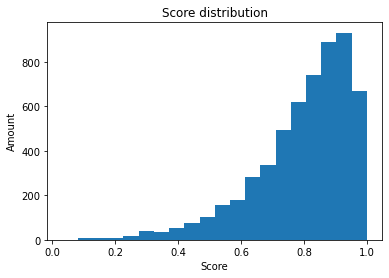

In [97]:
# calculate score
score = (df.total_positive/df.total_reviews)

# plot distribution
plt.hist(score, bins=20)
plt.xlabel("Score")
plt.ylabel("Amount")
plt.title("Score distribution")
